## File created by Reid Wyde


### Last updated 8.27.19

### TODO

add growth equations

display differential, display parameters fitted for each graph

add a per group expectation on the prior


figure out why nuts fails to initialize

add BIC and configure pymc3 for posterior information criterion

configure theano for multiple cores // windows issue, not possible right now


#### growth equations 

exponential growth

ernesto's equations

skillman

nth root

gompertz

inverse nth root

hanfeldt

ergun

logistic growth





<div>
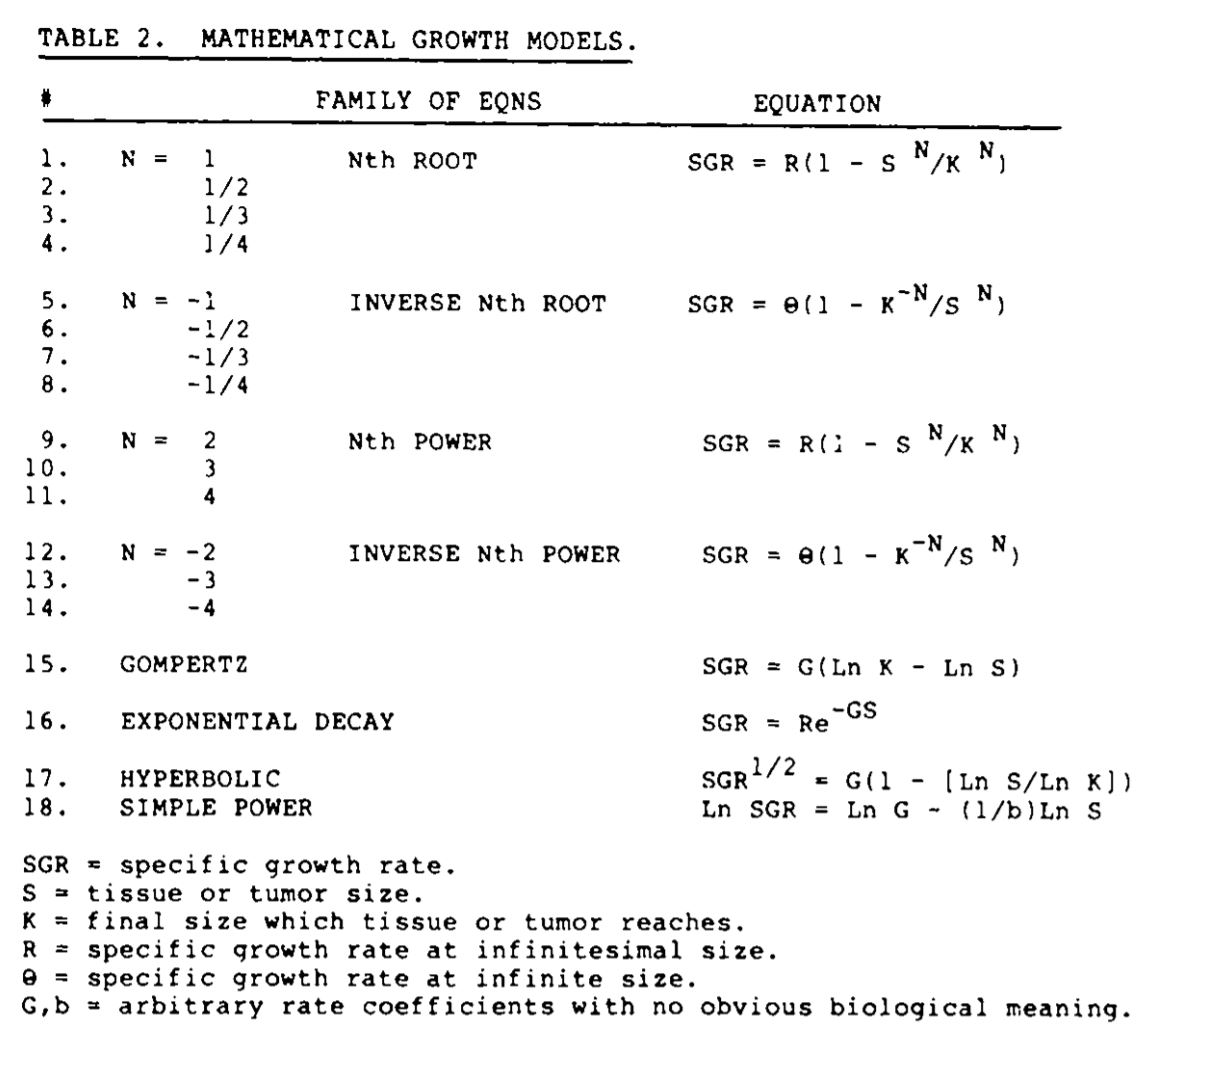
</div>

In [1]:
import pandas as pd
import numpy as np
print(np.__version__)
import theano
print(theano.__version__)
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# This makes the plots appear inside the notebook
%matplotlib inline
import pymc3 as pm
# Initialize random number generator
np.random.seed(123)

import os
import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.integrate import odeint


1.16.4
1.0.4


In [2]:
dirname = os.getcwd()
filename = dirname + '\..\data\\tumor_size_db.csv'
tumor_size_db = pd.read_csv(filename)
tumor_size_db.head()

Day      G1_avg       G1_sd      G2_avg      G2_sd      G3_avg       G3_sd  \
0    7   53.973689   19.464756   27.939597  19.032486   44.872119   20.290405   
1   14   56.730533   34.316923   47.079148  26.709641   59.175717   41.133786   
2   23   90.677211   51.384002   61.140151  31.821015  112.524376   51.204812   
3   29  182.971051   96.268908  127.343047  61.519414  211.247381  127.305794   
4   34  284.888364  147.891820  225.843888  92.229404  346.168185  147.788359   

       G4_avg       G4_sd      G5_avg       G5_sd      G6_avg       G6_sd  
0   38.955318   21.359080   30.988742   17.752230   42.366388   13.069455  
1   39.697439   29.993253   34.640653   25.398323   52.488467   23.978783  
2   75.404253   68.348904   61.905680   33.892752  118.747997   71.618255  
3  217.351729  153.788112  134.994293   65.107710  182.961115  103.520392  
4  388.344451  247.451969  257.324806  123.482982  267.228868  140.192699

In [3]:
#forward model

# the way this is set up is as follows: we have the algorithm for solving the forward problem, which is runge kutta, defined first
# the second definition is the class for the particular model, which extends object. 

#for each model there will be a similar class definition

#the th_forward_model is a wrapper that is called so that we can pass a stochastic variable to the forward solver
theano.config.exception_verbosity= 'high'

def rungeKutta(ts, y0, dydt, params): 
    ys = np.zeros((len(ts),len(y0)))
    ys[0] = y0
    y = y0

    for i in range(1,(len(ts))) :
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        #print(t0)
        #print(y)
        #print(h)
        k1 = h * dydt(y, params) 
        k2 = h * dydt(y + 0.5 * k1, params) 
        k3 = h * dydt(y + 0.5 * k2, params) 
        k4 = h * dydt(y + k3, params) 

        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        ys[i] = y

    #print('rk returns')
    return ys

 
    
#there needs to be as many tt.dscalars as there are parameters
#this function handle implicitly requires that 
#@as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix]) 
#def th_forward_model(params):
#    th_states = ode_model.simulate(params)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
#    return th_states

class exp_growth_model(object):
    def __init__(self, times, y0):
            self._times = times
            self._y0 = y0
    def _simulate(self, params, times):
        def dydt(y, param):
            return np.array(y)*param
        #values = odeint(dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, [self._y0], dydt, params)
        return values

    def simulate(self, params, times=None):
        if times is None: times = self._times
        return self._simulate(params, times)
    
    def backward(self, y_obs, sigma):
        with pm.Model():
            alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            @as_op(itypes=[tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(params):
                th_states = self.simulate(params)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                return th_states
            
            forward = th_forward_model(alpha)
            
            y = pm.Normal('y', mu=forward, sigma = sigma, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 3
            startsmc=[{'alpha':np.random.uniform(0.041, 0.059,1)} for _ in range(n_chains)]
            #self.trace = pm.sample(1000, chains=n_chains, start=startsmc, cores=1, tune = 100)
            self.trace = pm.sample(600, tune=100, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    


In [4]:

def get_datacol(colidx):
    x_data = np.array(tumor_size_db['Day']).reshape(-1,1)
    y_data = np.array(tumor_size_db['G'+str(colidx)+'_avg']).reshape(-1,1)
    y_err = np.array(tumor_size_db['G'+str(colidx)+'_sd']).reshape(-1,1)
    return (x_data,y_data,y_err)

[ 7 14 23 29 34 35 36 37 40 42 44 47 49 51 54 56 61 63 68]
[[53.97368929]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
Slice: [alpha]
100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:04<00:00, 150.90it/s]


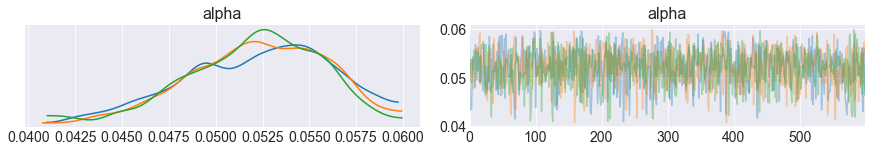

In [5]:
#fit the exponential model to each of the groups

init_times = np.array(tumor_size_db['Day']).reshape(1,-1)[0]
print(init_times)
init_y0 = np.array(tumor_size_db['G1_avg'][0]).reshape(-1,1)
print(init_y0)

exp1 = exp_growth_model(init_times,init_y0)
exp1.backward(get_datacol(1)[1],get_datacol(1)[2])




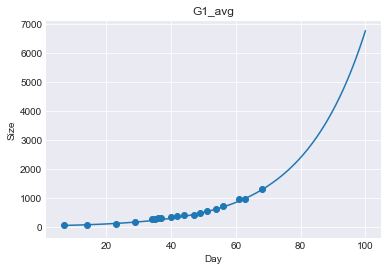

In [6]:
Y_sim = exp1.simulate(exp1.get_param('alpha'),np.linspace(7,100,1000))

#plot the exponential model vs the groups
plt.plot(np.linspace(7,100,1000), Y_sim)
plt.scatter(tumor_size_db['Day'], tumor_size_db['G1_avg'])
plt.title('G1_avg')
plt.xlabel('Day')
plt.ylabel('Size')


plt.show()


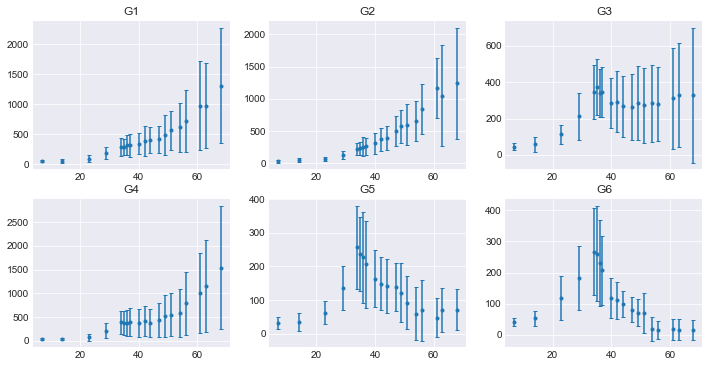

In [7]:
def graph_datacol(colidx, dataset='default'):
    if dataset=='default':
        x_data = np.array(tumor_size_db['Day']).reshape(-1,)
        y_data = np.array(tumor_size_db['G'+str(colidx)+'_avg']).reshape(-1,)
        y_err = np.array(tumor_size_db['G'+str(colidx)+'_sd']).reshape(-1,)
        plt.errorbar(x_data, y_data,y_err,fmt='.',capsize=2)
        plt.title('G'+str(colidx))

def graph_dataset():
    plt.figure(figsize=[12,6])
    #x_data = np.array(tumor_size_db['Day']).reshape(1,-1)[0]
    for ii in range(1,7):
        plt.subplot(2,3,ii)
        #plt.title('G'+str(ii))
        graph_datacol(ii)
    plt.show()

graph_dataset()
    

In [9]:
#fit model, generate output, store output, graph output

sim_times = np.linspace(0,70,100)

def fit_model(model_type, x_data, y_data, sigma):
    this_model = model_type(x_data, y_data[0])
    this_model.backward(y_data,sigma)
    return this_model

def simulate_model(model, times):
    #print(model.get_param('alpha'))
    y_sim = model.simulate(model.get_param('alpha'),times)
    #print(times.shape)
    #print(y_sim.shape)
    #print(times)
    #print(y_sim)
    return np.concatenate((times.reshape(1,-1), y_sim.reshape(1,-1)),axis=0)

def fit_sim_all_data(model_type):
    ret = np.empty([6,2,100])
    for ii in range(1,7):
        this_col= get_datacol(ii)
        fitted_model = fit_model(model_type, this_col[0], this_col[1], this_col[2])
        ret[ii-1] = simulate_model(fitted_model,sim_times)
    return ret

def graph_all_sim(model_type):
    data = fit_sim_all_data(model_type)
    plt.figure(figsize=[12,6])
    #print(data.shape)
    #print(data[0].shape)
    for ii in range(1,7):
        plt.subplot(2,3,ii)
        graph_datacol(ii)
        plt.plot(data[ii-1][0],data[ii-1][1])
        plt.xlabel('Day')
        plt.ylabel('Size')


In [8]:
def get_datacol(colidx):
    x_data = np.array(tumor_size_db['Day']).reshape(-1,1)
    y_data = np.array(tumor_size_db['G'+str(colidx)+'_avg']).reshape(-1,1)
    y_err = np.array(tumor_size_db['G'+str(colidx)+'_sd']).reshape(-1,1)
    ret = np.array([x_data, y_data, y_err])
    #print('get_datacol')
    #print(ret.shape)
    return ret

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
Slice: [alpha]
100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:04<00:00, 167.04it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
Slice: [alpha]
100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:03<00:00, 176.07it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
Slice: [alpha]
100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:03<00:00, 183.83it/s]
Auto-assigning NUTS sampler...
Ini

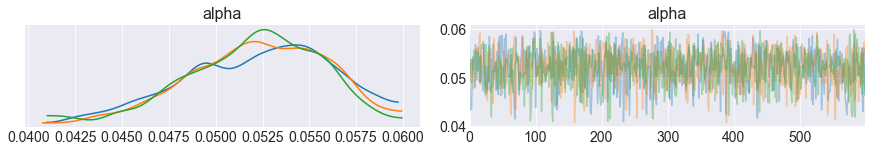

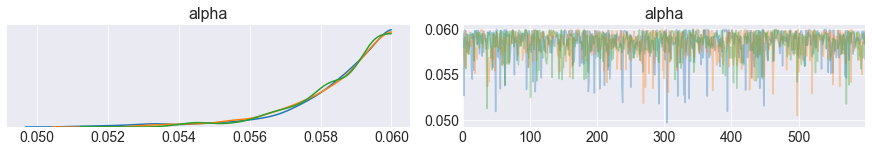

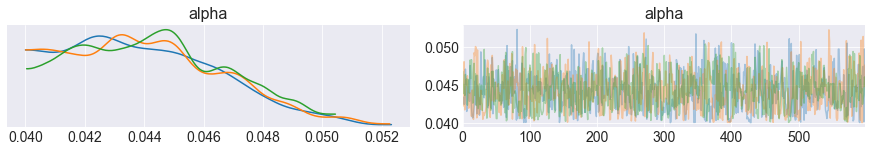

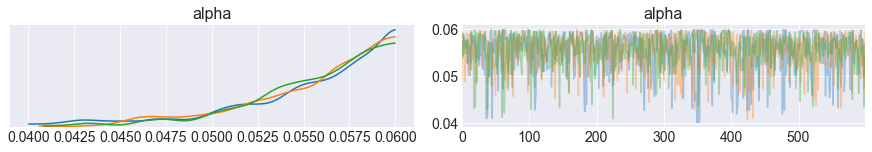

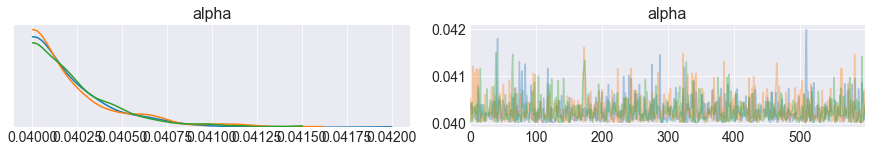

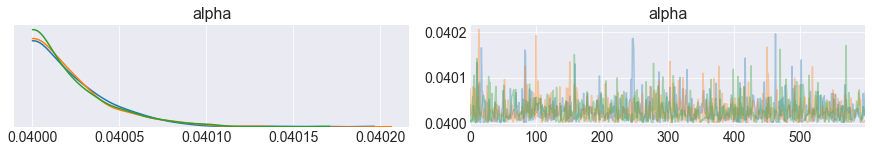

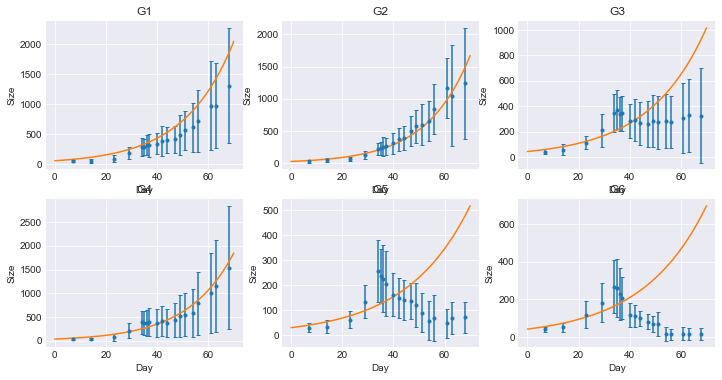

In [14]:

graph_all_sim(exp_growth_model)

exp1_dense_times = exp1
exp1_dense_times.times = np.linspace(0,100,10000)
Y_sim = exp1_dense_times.simulate(exp1.get_param('alpha'))

#plot the exponential model vs the groups
plt.plot(tumor_size_db['Day'], Y_sim)
plt.scatter(tumor_size_db['Day'], tumor_size_db['G1_avg'])
plt.title('G1_avg')
plt.xlabel('Day')
plt.ylabel('Size')


plt.show()


## Model 2 - Logistic Growth

In [10]:
def simulate_model(model, times):
    #print(model.get_param('alpha'))
    y_sim = model.simulate(model.get_param('alpha'),model.get_param('K'),times)
    #print(times.shape)
    #print(y_sim.shape)
    #print(times)
    #print(y_sim)
    return np.concatenate((times.reshape(1,-1), y_sim.reshape(1,-1)),axis=0)

In [13]:

class logistic_growth_model(object):
    def __init__(self, times, y0):
            self._times = times
            self._y0 = y0
    def _simulate(self, params, times):
        def dydt(y, params):
            first = params[0]*np.array(y)
            second = (1-(np.array(y)/params[1]))
            return first*second
        #values = odeint(dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, [self._y0], dydt, params)
        #print(values)
        return values

    def simulate(self, alpha, K, times=None):
        params = [alpha, K]
        if times is None: times = self._times
        return self._simulate(params, times)
    
    def backward(self, y_obs, sigma):
        with pm.Model():
            alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            K = pm.Uniform('K', lower=50, upper=300)
            
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(alpha, K):
                th_states = self.simulate(alpha, K)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                return th_states
            
            forward = th_forward_model(alpha,K)
            
            y = pm.Normal('y', mu=forward, sigma = sigma, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 3
            startsmc=[{'alpha':np.random.uniform(0.041, 0.059),'K':np.random.uniform(51,299)} for _ in range(n_chains)]
            #self.trace = pm.sample(1000, chains=n_chains, start=startsmc, cores=1, tune = 100)
            self.trace = pm.sample(600, tune=100, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:08<00:00, 78.67it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:10<00:00, 68.81it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [alpha]
100%|███████████████████████████████████████████████████████████████████████

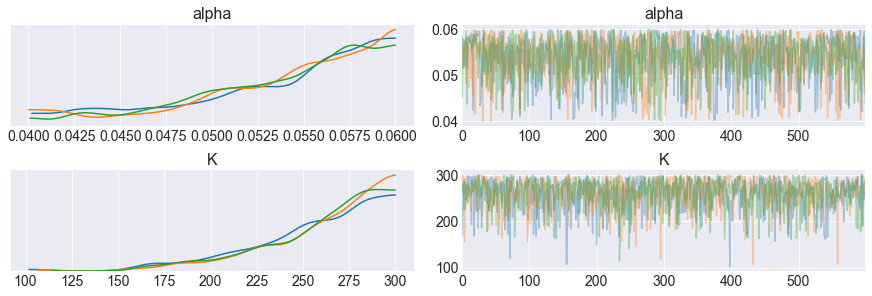

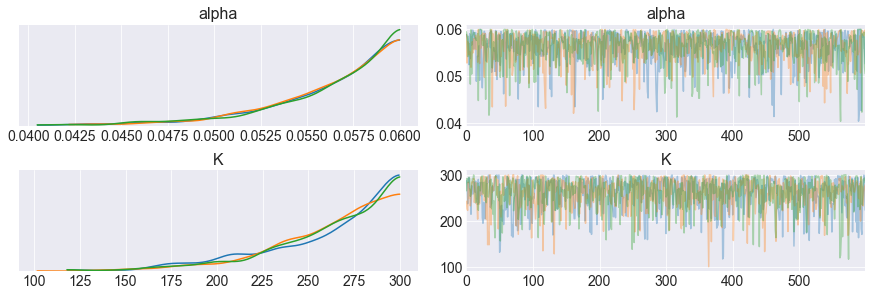

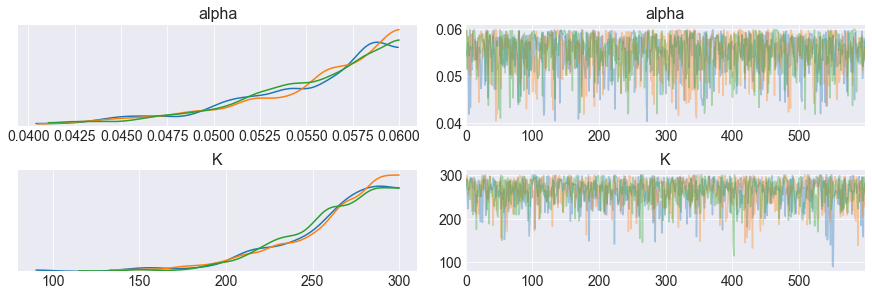

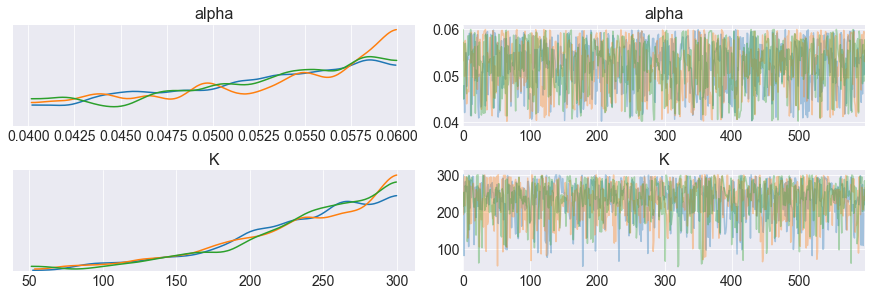

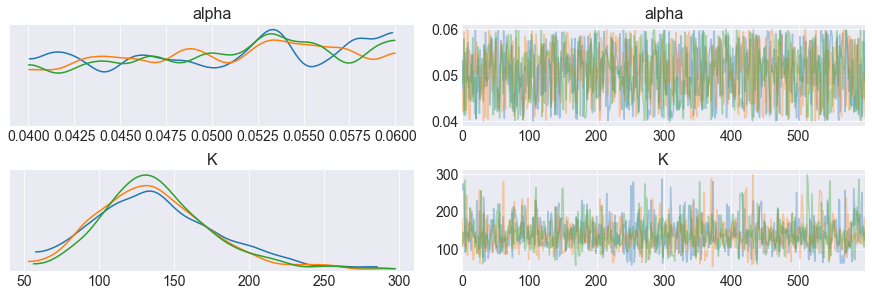

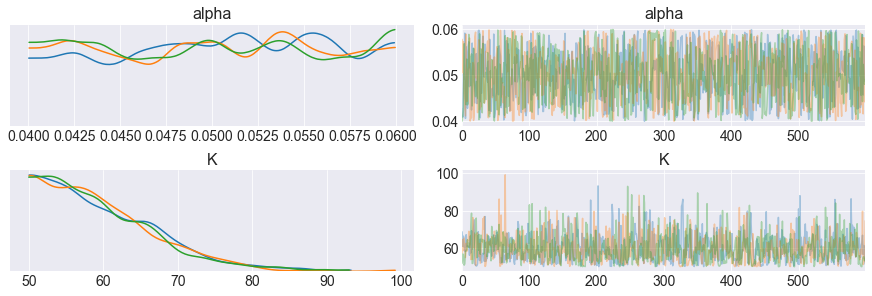

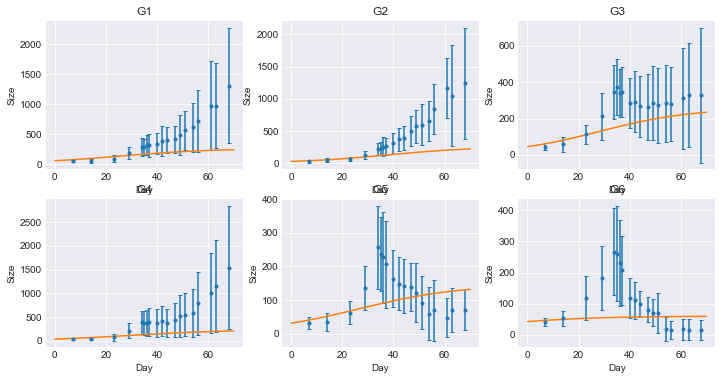

In [14]:
graph_all_sim(logistic_growth_model)

In [20]:
def simulate_model(model, times):
    #print(model.get_param('alpha'))
    y_sim = model.simulate(model.get_param('alpha'),model.get_param('allee'),times)
    #print(times.shape)
    #print(y_sim.shape)
    #print(times)
    #print(y_sim)
    return np.concatenate((times.reshape(1,-1), y_sim.reshape(1,-1)),axis=0)

class allee_growth_model_1(object):
    def __init__(self, times, y0):
            self._times = times
            self._y0 = y0
    def _simulate(self, params, times):
        def dydt(y, params):
            first = params[0]*np.array(y)     #dividing into steps makes debugging easier
            second = ((np.array(y)/params[1])-1)
            return first*second
        #values = odeint(dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, [self._y0], dydt, params)
        #print(values)
        return values

    def simulate(self, alpha, allee, times=None):
        params = [alpha, allee]
        if times is None: times = self._times
        return self._simulate(params, times)
    
    def backward(self, y_obs, sigma):
        with pm.Model():
            alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            allee = pm.Uniform('allee', lower=50, upper=300)
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(alpha, allee):
                th_states = self.simulate(alpha, allee)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                return th_states
            
            forward = th_forward_model(alpha,allee)
            
            y = pm.Normal('y', mu=forward, sigma = sigma, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 3
            startsmc=[{'alpha':np.random.uniform(0.041, 0.059),'allee':np.random.uniform(51,299)} for _ in range(n_chains)]
            #self.trace = pm.sample(1000, chains=n_chains, start=startsmc, cores=1, tune = 100)
            self.trace = pm.sample(600, tune=100, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [allee]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:08<00:00, 77.91it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [allee]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:09<00:00, 77.52it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [allee]
>Slice: [alpha]
100%|███████████████████████████████████████████████████████████

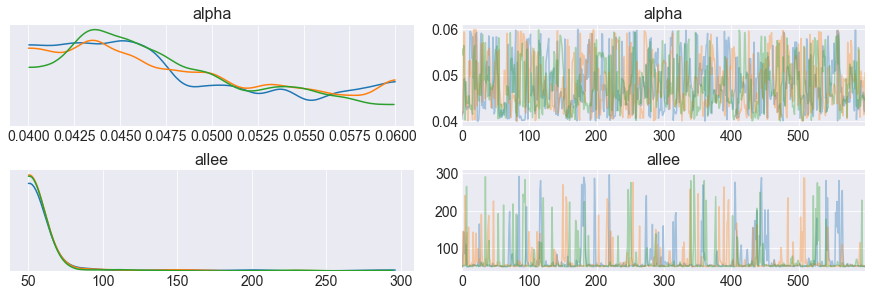

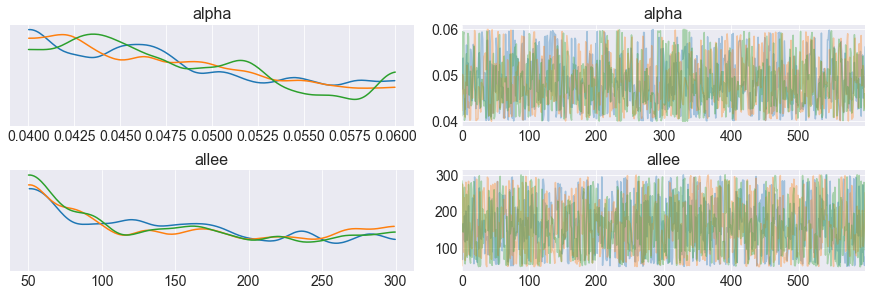

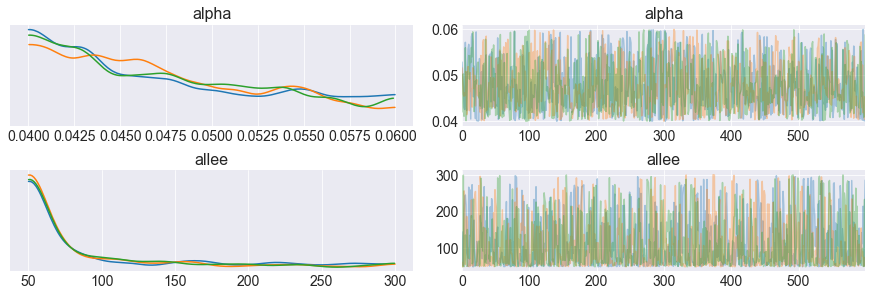

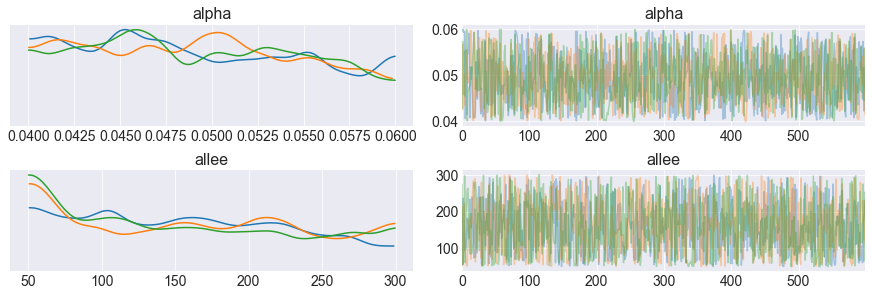

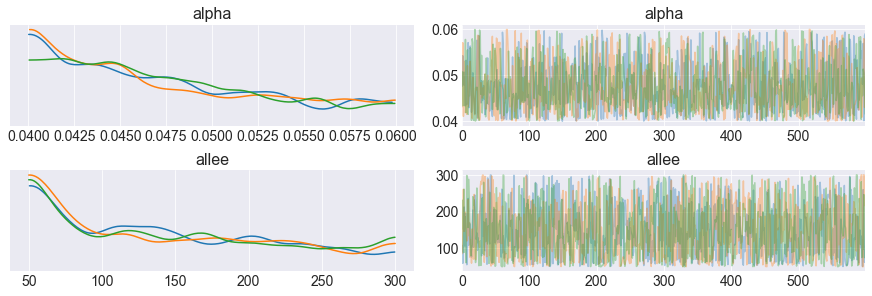

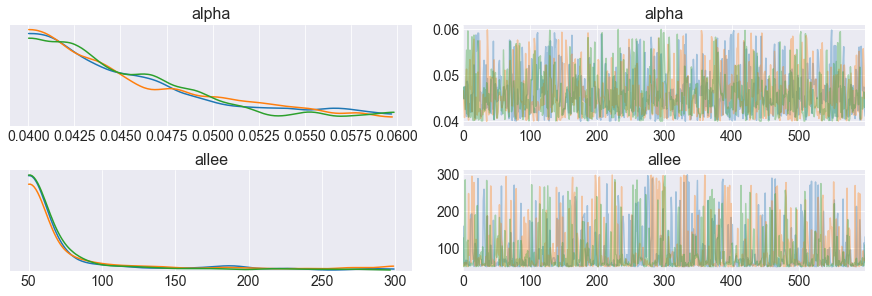

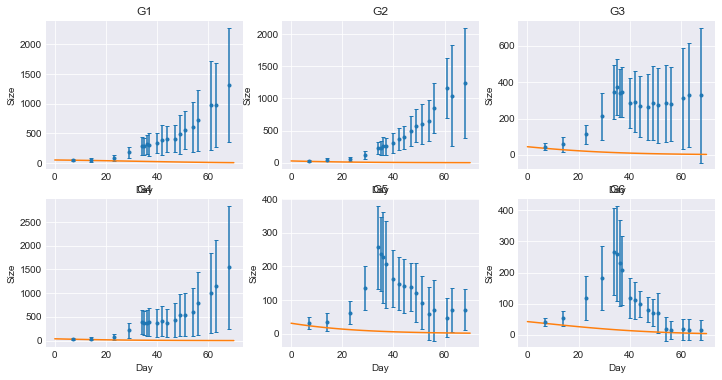

In [17]:
graph_all_sim(allee_growth_model_1)

In [22]:
def simulate_model(model, times):
    #print(model.get_param('alpha'))
    y_sim = model.simulate(model.get_param('alpha'),model.get_param('allee'),model.get_param('K'),times)
    #print(times.shape)
    #print(y_sim.shape)
    #print(times)
    #print(y_sim)
    return np.concatenate((times.reshape(1,-1), y_sim.reshape(1,-1)),axis=0)

class allee_growth_model_2(object):
    def __init__(self, times, y0):
            self._times = times
            self._y0 = y0
    def _simulate(self, params, times):
        def dydt(y, params):
            first = params[0]*np.array(y)     #dividing into steps makes debugging easier
            second = ((np.array(y)/params[1])-1)
            third = (1-np.array(y)/params[2])
            return first*second*third
        #values = odeint(dydt, self._y0[0], times, (params,),rtol=1e-6,atol=1e-6)
        values = rungeKutta(times, [self._y0], dydt, params)
        #print(values)
        return values

    def simulate(self, alpha, allee, K, times=None):
        params = [alpha, allee, K]
        if times is None: times = self._times
        return self._simulate(params, times)
    
    def backward(self, y_obs, sigma):
        with pm.Model():
            alpha = pm.Uniform('alpha', lower=0.04, upper=0.06) #change this to be external
            allee = pm.Uniform('allee', lower=50, upper=300)
            K = pm.Uniform('K', lower=50, upper=300)
            @as_op(itypes=[tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(alpha, allee, K):
                th_states = self.simulate(alpha, allee, K)  # i think we could change this to pass times as well, which would avoid the need to instantiate the model with times
                return th_states
            
            forward = th_forward_model(alpha,allee, K)
            
            y = pm.Normal('y', mu=forward, sigma = sigma, observed=y_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 3
            startsmc=[{'alpha':np.random.uniform(0.041, 0.059),'allee':np.random.uniform(51,299),'K':np.random.uniform(51,299)} for _ in range(n_chains)]
            #self.trace = pm.sample(1000, chains=n_chains, start=startsmc, cores=1, tune = 100)
            self.trace = pm.sample(600, tune=100, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    def get_param(self, param_name, n=100):
        return sum(self.trace[param_name][-n:])/n
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [allee]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:17<00:00, 39.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [allee]
>Slice: [alpha]
100%|████████████████████████████████████████████████████████████████████████████████| 700/700 [00:18<00:00, 38.15it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
CompoundStep
>Slice: [K]
>Slice: [allee]
>Slice: [alpha]
100%|███████████████████████

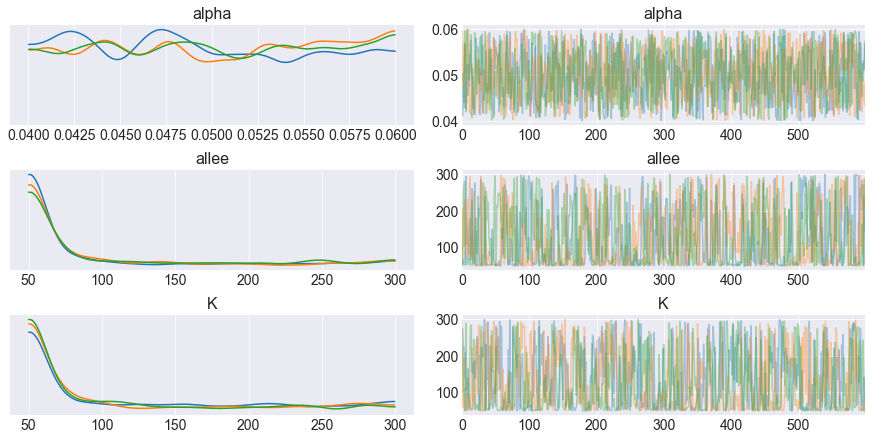

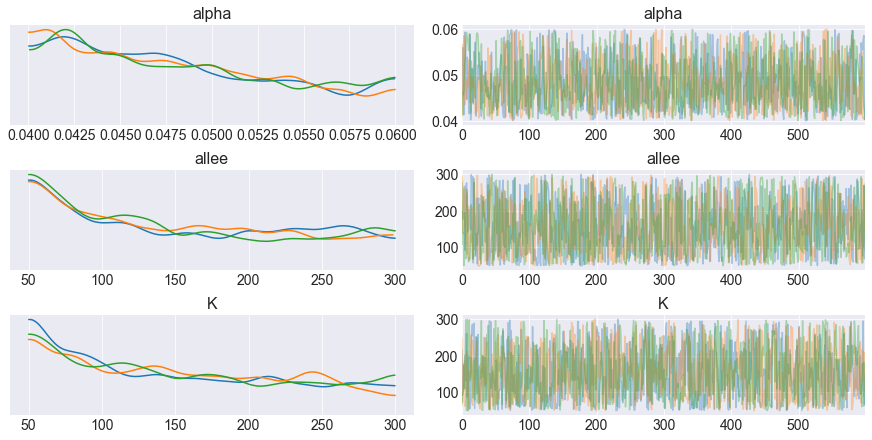

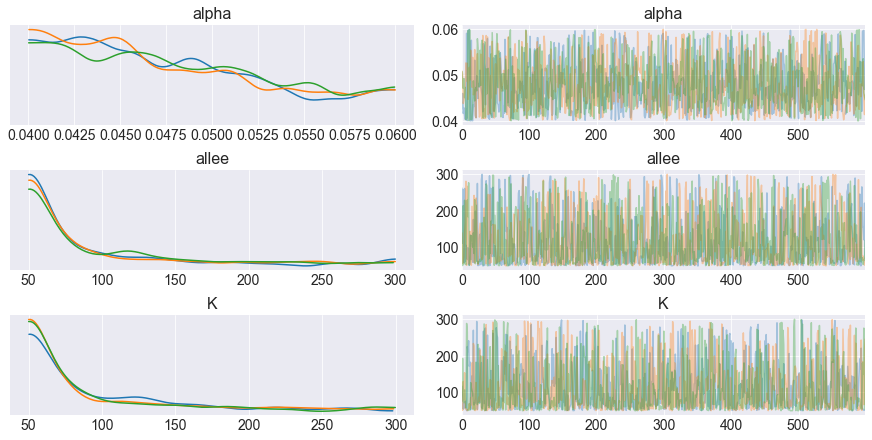

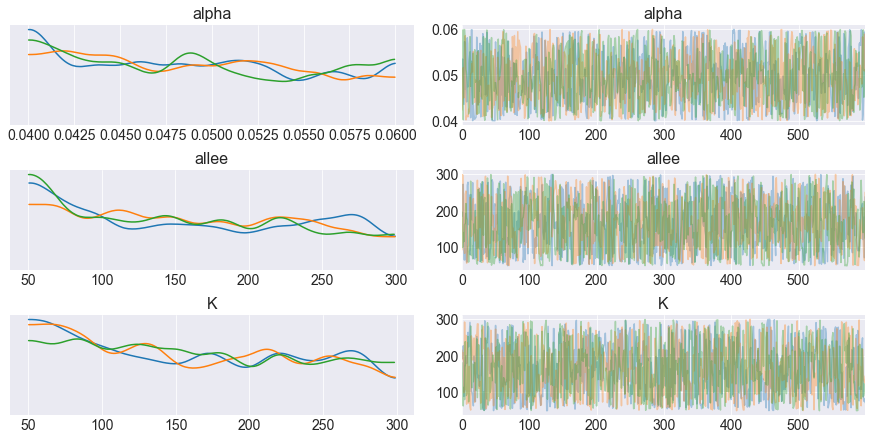

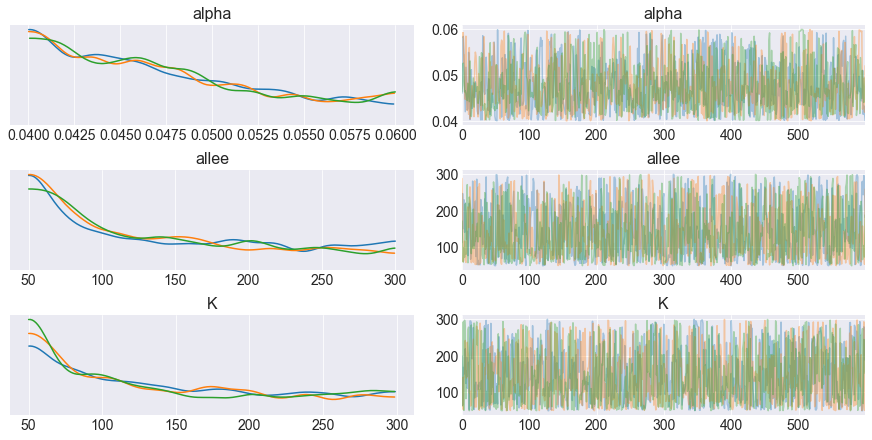

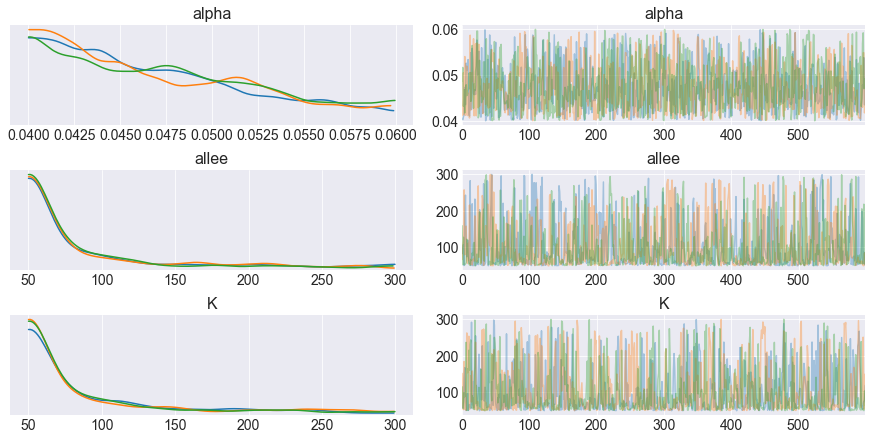

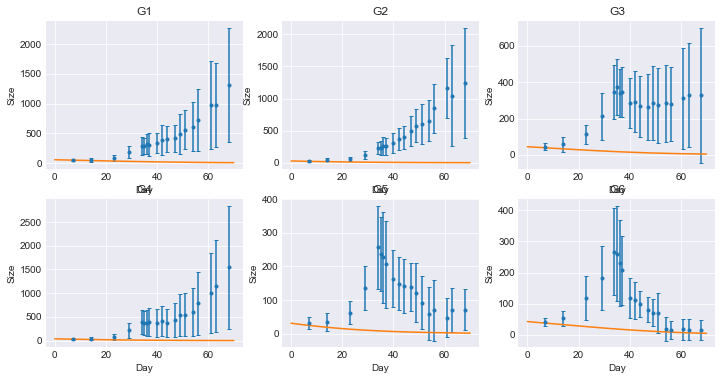

In [23]:
graph_all_sim(allee_growth_model_2)